## 1. Introduction

## PSET #1 By Zachary Mariani
### Student ID # 12188511, so 5 and 1

In [1]:
#standard imports 
import pandas as pd 
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import quandl
import functools

my_api_key = HIDDEN
pd.set_option("max_columns", None) 
pd.set_option("max_rows", None)

## 2. Data 
Obtain second month futures prices from the Quandl OWF database for two pair W, X; Y, Z (where W, X and Y and Z depend on your student ID number) for 3 Dec 2018 though 31 Aug 2020. 

Our definition of second month is the contact where the number of days to futures expiration is the smallest available value greater than 30. In other words, for each date in the analysis date range, you have to have all available futures contracts for that date. Then choose the one with lowest time to expiration so long as it is over 30 days. 

Form the spreads s_t^1, s_t^2 between these numbers as the difference s_t^1 = X_t - W_t and s_t^2 = Z_t − Y_t .

In [2]:
month_codes = \
    ['H','M', 'U','Z']
    
year_codes = \
    ['2018', '2019', '2020']

def get_raw_data(month, year):
    """
    Inputs: 
        month: a string corresponding to the month code 
        year: a string corresponding to the year
        
    Returns: 
        a list of four datasets corresponding to my unique W, X, Y, and Z 
          dataframes for that month/year combination's contract
    """
    
    W = 'OWF/CBT_FV_FV_%s%s_IVM' %(month, year)
    X = 'OWF/CBT_TY_TY_%s%s_IVM' %(month, year)
    Y = 'OWF/ICE_B_B_%s%s_IVM' %(month, year)
    Z = 'OWF/ICE_G_G_%s%s_IVM' %(month, year) #will need the (1/7.45) multiplier 
 
    secs = [W, X, Y, Z]
    labels = ['W', 'X', 'Y', 'Z']

    W_df = quandl.get(secs[0], returns = 'pandas', 
            api_key = my_api_key, start_date = '2018-12-03', end_date = '2020-08-31')
    #we only need these two columns 
    W_df = W_df[['Future', 'DtT']]
    #anything less than 30 we set to none as per the parameters 
    W_df['DtT'][W_df['DtT'] <= 30] = None
    W_df['sec'] = 'W'
    W_df['contract'] = month + year
    
    X_df = quandl.get(secs[1], returns = 'pandas', 
            api_key = my_api_key, start_date = '2018-12-03', end_date = '2020-08-31')
    X_df = X_df[['Future', 'DtT']]
    X_df['DtT'][X_df['DtT'] <= 30] = None
    X_df['sec'] = 'X'
    X_df['contract'] = month + year
    
    Y_df = quandl.get(secs[2], returns = 'pandas', 
            api_key = my_api_key, start_date = '2018-12-03', end_date = '2020-08-31')
    Y_df = Y_df[['Future', 'DtT']]
    Y_df['DtT'][Y_df['DtT'] <= 30] = None
    Y_df['sec'] = 'Y'
    Y_df['contract'] = month + year
    
    Z_df = quandl.get(secs[3], returns = 'pandas', 
            api_key = my_api_key, start_date = '2018-12-03', end_date = '2020-08-31')
    Z_df = Z_df[['Future', 'DtT']]
    Z_df['DtT'][Z_df['DtT'] <= 30] = None
    Z_df['sec'] = 'Z'
    Z_df['contract'] = month + year
    
    return [W_df, X_df, Y_df, Z_df]


#we first generate empty dfs for each of the securities 
W_full = pd.DataFrame()
X_full = pd.DataFrame()
Y_full = pd.DataFrame()
Z_full = pd.DataFrame()

#then we loop through all the month/year combinations to make pairs and extend
#the dfs for each security 
for year in year_codes: 
    for month in month_codes:
        
        temp_w, temp_x, temp_y, temp_z = get_raw_data(month, year)
        
        W_full = W_full.append(temp_w)
        X_full = X_full.append(temp_x)
        Y_full = Y_full.append(temp_y)
        Z_full = Z_full.append(temp_z)
        
lst_of_df = [W_full, X_full, Y_full, Z_full]


#this sorts the value by first the date and then the DtT
for df in lst_of_df: 
    df.sort_values(by = ['Date', 'DtT'], inplace=True)

#we then keep the first index (ie. the date) and throw out the others to only get the most recent
#this method helps us get the best second month contract (and do so quickly)
#as per the parameters of the assignment

lst_of_df[0] = lst_of_df[0][~lst_of_df[0].index.duplicated(keep='first')]
lst_of_df[1] = lst_of_df[1][~lst_of_df[1].index.duplicated(keep='first')]
lst_of_df[2] = lst_of_df[2][~lst_of_df[2].index.duplicated(keep='first')]
lst_of_df[3] = lst_of_df[3][~lst_of_df[3].index.duplicated(keep='first')]

Now that we have assembled all of the raw data, we will calculate the spreads 

In [3]:
multiplier = 1/7.45


#intiate a new, empty df for spreads 
spreads = pd.DataFrame()

spreads['x_minus_w'] = lst_of_df[1]['Future'] - lst_of_df[0]['Future']
spreads['z_minus_y'] = (lst_of_df[3]['Future']) * multiplier - lst_of_df[2]['Future']

'''
Check to see if my spreads are correct:

5: 
CBTFVFV CBTTYTY
2019-08-16 11.421875 - good 
2019-08-23 11.710938 - good 


1: 
ICEBB ICEGG
2019-06-27 14.799799 - good 
2019-08-13 16.264966 - good

'''
print(spreads.loc['2019-08-16'], '\n\n', spreads.loc['2019-08-23'], '\n\n', \
      spreads.loc['2019-06-27'], '\n\n', spreads.loc['2019-08-13'])

x_minus_w    11.421875
z_minus_y    16.860201
Name: 2019-08-16 00:00:00, dtype: float64 

 x_minus_w    11.710938
z_minus_y    16.168859
Name: 2019-08-23 00:00:00, dtype: float64 

 x_minus_w     9.781250
z_minus_y    14.799799
Name: 2019-06-27 00:00:00, dtype: float64 

 x_minus_w    11.062500
z_minus_y    16.264966
Name: 2019-08-13 00:00:00, dtype: float64


## 3. Analysis 

Once we have calculated the spreads, we will analyze them

Information for N = 5


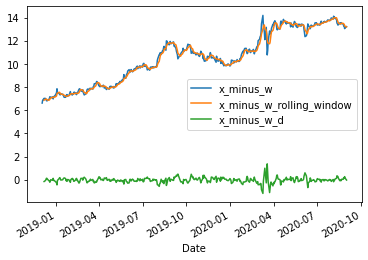

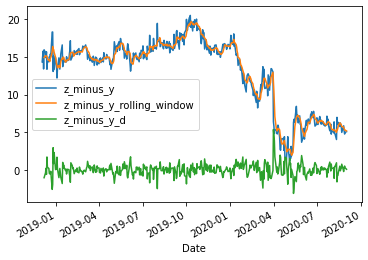

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:323: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


Information for N = 252


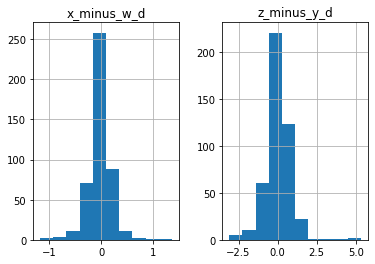

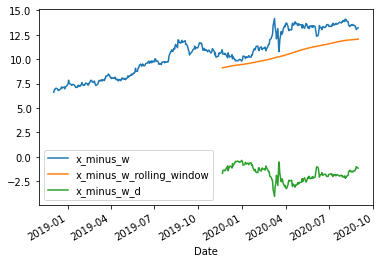

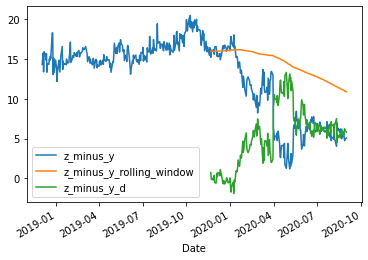

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:323: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


Information for N = 28


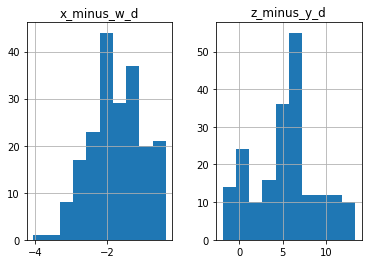

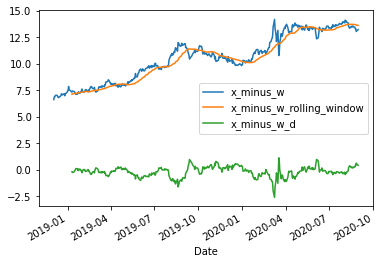

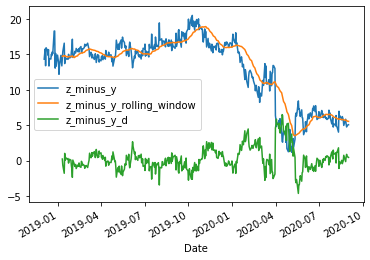

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:323: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


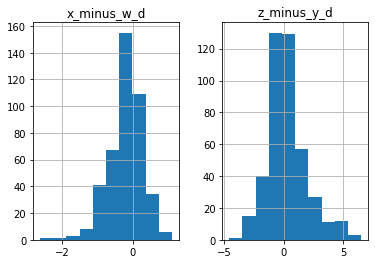

In [4]:
def compute_median_and_std(N):
    #first, there are some gaps in the data directly imported from Quandl
    spreads['x_minus_w'].fillna(value=None, method='ffill', inplace=True)
    spreads['z_minus_y'].fillna(value=None, method='ffill', inplace=True)

    #second, create the rolling mean 
    spreads['x_minus_w_rolling_window'] = spreads['x_minus_w'].rolling(window=N).mean()
    spreads['z_minus_y_rolling_window'] = spreads['z_minus_y'].rolling(window=N).mean()

    #thrid, find differences 
    spreads['z_minus_y_d'] = spreads['z_minus_y_rolling_window'] - spreads['z_minus_y']
    spreads['x_minus_w_d'] = spreads['x_minus_w_rolling_window'] - spreads['x_minus_w']


    spreads.plot(y=['x_minus_w', 'x_minus_w_rolling_window', 'x_minus_w_d'])
    plt.show()

    spreads.plot(y=['z_minus_y', 'z_minus_y_rolling_window', 'z_minus_y_d'])
    plt.show()

    spreads.hist(column=['z_minus_y_d','x_minus_w_d'])
    
print('Information for N = 5')
compute_median_and_std(5)

print('Information for N = 252')
compute_median_and_std(252)

print('Information for N = 28')
compute_median_and_std(28)



From the work above, we can see that for the x_minus_w_d most of the time, d is between -1.5 and 0.5, z_minus_y_d has a much wider range, going all the way from -5 to roughly 5. We all describe some fast facts below:

In [5]:
print(spreads['z_minus_y_d'].describe(), '\n\n\n')
print(spreads['x_minus_w_d'].describe())

count    425.000000
mean       0.287236
std        1.679734
min       -4.605002
25%       -0.730635
50%        0.075858
75%        0.987442
max        6.505441
Name: z_minus_y_d, dtype: float64 



count    425.000000
mean      -0.198098
std        0.479341
min       -2.622768
25%       -0.434152
50%       -0.155971
75%        0.126395
max        1.119141
Name: x_minus_w_d, dtype: float64


z_minus_y x_minus_w


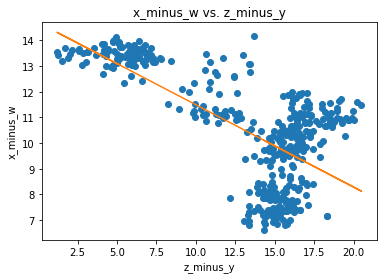

In [6]:
'''
Examine more quantiles than just the median.  
Look at tails.  
Do the spreads correlate? 
How about their difference (d) values? 
Do spreads exhibit patternsover time?
'''


def generate_correlation_graph(x, y):
    '''
    Inputs:
        x: a Pandas dataseries 
        y: a Pandas dataseries 
    Returns: 
        a scatter plot of Y vs. X with a regression line 
          the graph includes a title of Y vs. X
    '''
    x_title = x.name
    y_title = y.name 
    
    x.dropna(inplace=True)
    y.dropna(inplace=True)

    # print(x, y)
    plt.plot(x, y, 'o')

    m, b = np.polyfit(x, y, 1)
    plt.xlabel(x_title)
    plt.ylabel(y_title)
    plt.title(y_title + ' vs. ' + x_title)
    plt.plot(x, m*x+b)
    print(x_title, y_title)

    
x = spreads['z_minus_y']
y = spreads['x_minus_w']
generate_correlation_graph(x,y)


z_minus_y_d x_minus_w_d


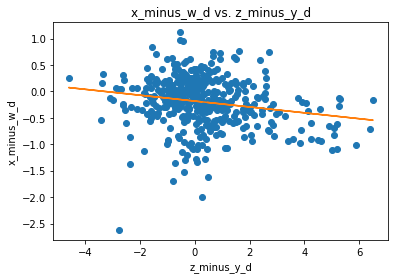

In [7]:
x = spreads['z_minus_y_d']
y = spreads['x_minus_w_d']
generate_correlation_graph(x,y)

### To respond to the questions:

Do the spreads correlate?

We see above that there are in fact some negative correlations between the spreads. It appears that as one gets larger the other gets smaller and vice versa as seen in the graph above labeled "x_minus_w vs. z_minus_y". 

How about their difference (d) values? 

We again see above that their difference values are also negatively correlated but much less so than strictly the spreads. 

Do spreads exhibit patterns over time? 

We see (several cells above) that the spreads have trends over time. x_minus_w seems to trend positive over time, meanwhile, z_minus_y seems to trend positive over time. We also see that there are periods when the spreads' movements become more or less volatile. It seems that these moments when markets are more volatile affect both of the spreads, however, we do see that z_minus_y seems more volatile than x_minus_w. 